In [1]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io
import scipy

import pyriemann
from pyriemann.classification import KNearestNeighbor

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

from sklearn.neighbors import KNeighborsClassifier

In [2]:
data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01'
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()


In [3]:
########################################
## Fonctions pour manipuler le signal:##
########################################

def reshape(signal):
    (a,b,c)=signal.shape
    output=np.zeros((b,a*c))
    for i in range (a):
        for j in range (b):
            output[j,i*500:(i+1)*500]=signal[i,j,:]
    return (output)

def correlation_threshold(signal,fenetre, indice,k=10**(-10)):
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
    (a,b)=corr.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if corr[i,j]>k:
                threshold[i,j]=1
    return threshold

def covariance_threshold(signal,fenetre, indice,k=10**(-10)):
    cov= np.cov(signal[:,indice:indice+fenetre])
    print(signal[:,indice:indice+fenetre].shape)
    (a,b)=cov.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if cov[i,j]>k:
                threshold[i,j]=1
    return threshold

def signal_freq_filtre(signal,freqs,fenetre):
    tf=np.fft.fft(signal)

    n = signal.size
    timestep = 1/250
    freq = np.fft.fftfreq(n, d=timestep)

    if freqs=='delta':
        waves=[0.5, 4.5]
    elif freqs=='beta':
        waves=[12 ,35.5]
    elif freqs=='theta':
        waves=[4, 8.5]
    elif freqs=='alpha':
        waves=[8, 12.5]
    elif freqs=='gamma':
        waves=[35, 1000]
    output=np.zeros(len(tf))
    for i in range (len(tf)):
        if i/2 > waves[1] or i/2<=waves[0]:
            tf[i]=0
    output=tf
    return(np.real(np.fft.ifft(output)))

def signalCourt(signal,ind, size):
    return signal[:,ind:ind+size]


def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): #signal analytique en input, renvoi la phase du signal
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): #signal analytique en input, renvoi l'enveloppe du signal
    return abs(x)

####################################
## Fonction de calcul de matrices:##
####################################

def matPLV(signal, fenetre, indice, freq): #output: la matrice de phase locking values
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[j],freq,fenetre)))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq): #output: la matrice de phase lag index
    B=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
        
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

def matInfoMut(signal, indice, fenetre,bins):
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            

            X_norm=signalCourt(signalTotal,indice,fenetre)[i]
            Y_norm=signalCourt(signalTotal,indice,fenetre)[j]
            c_xy = np.histogram2d(X_norm, Y_norm, bins)[0]
            mi= mutual_info_score(None, None, contingency=c_xy)
            A[i,j]=mi
            
    return (A)

alphaTable=np.array([[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
                    [0,0,2,3,5,8,10,13,17,21,25,29,34,40,46,52,58,65,73,81,89,98,107,116,126,137]])

def monoExp(x, m, t, b, c):
    return m * np.exp(t * x+c) + b

p0 = (1, 1, 1, 1) # valeurs initiales pour l'optimisation sequentielle
params, cv = scipy.optimize.curve_fit(monoExp, alphaTable[0][:], alphaTable[1][:], p0)
m, t, b, c = params
xs2 = np.arange(50)
ys2 = monoExp(xs2, m, t, b, c)


def matwPLWT(signal, ind, fenetre, freq): ##output: matrice PLWT de poids

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                PLWT=abs((tpos-tneg)/(tpos+tneg))
                A[i,j]=PLWT
    return (A)

def matPLWT(signal, ind, fenetre, freq,alpha=.05): #output:matrice PLWT binaire (utilisant l'approximation exponentielle pour n>30)

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                T=min(tpos, tneg)
                n=len(theta1)
                if (n<=30) :
                    Tc=alphaTable[1][n-5]
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                else:
                    sig=(n*(n+1)*(2*n+1)/24)
                    mu=n*(n+1)/4
                    Z=(T-mu)/(sig)
                    Zc=1.645 # basé sur gaussienne centrée réduite (ne marche pas)
                    if Z<Zc:
                        PLWT=1
                    else:
                        PLWT=0
                A[i,j]=PLWT
    return (A)
##########################################
## Fonction pour manipuler les matrices:##
##########################################
def emptyDiago(A): #output la matrice mais avec une diagonale vide
    for i in range (A.shape[0]):
        A[i,i]=0
    return (A)

def degreeMat(A): #output: matrice de degrée (termes des lignes sommées sur la diagonale)
    a,b=A.shape
    B=np.zeros((a,b))
    for i in range (a):
        s=0
        for j in range (b):
            s=s+A[i,j]
        B[i,i]=s
    return (B)

def laplacien(A): #renvoi la matrice ayant subit le laplacien
    return (degreeMat(emptyDiago(A))-emptyDiago(A))

def threshold(mat,k):
    return np.where(mat>k, 1,0)

def vectorise(mat):
    return mat[np.triu_indices(mat.shape[0],k=1)]



In [7]:
# Cette fonction créer un vecteur de taille ((n*N)*K) où n*N est le nombre d'instances où l'on calcule une statistique
# à travers les 6 sessions du sujet 1 (n:instants/session et N: nombre de sessions)
# K est la taille du vecteur qui provient de la matrice 61x61 --> K=(60*61)/2
# Output: Y qui est le vecteur qui contient 0,1 ou 2 en fonction de la difficulté de charge mentale

def makeTrain(N,n,taillef,frequence,mesure,bins=5 ): #n est le nombre d'instants par session, N est le nombre de sessions
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet'
    numberVect=np.array(['1','1','1','2','2','2'])
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med'])
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,1830))
    
    for k in range (M):
        array='/patient1/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec toutes les sessions d'un meme sujet réuni
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp)     
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n)
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
                mat=correlation_threshold(signalTotal2,taillef, indice)
            x[n*k+i,:]=vectorise(mat).T

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2
    return (x,y)



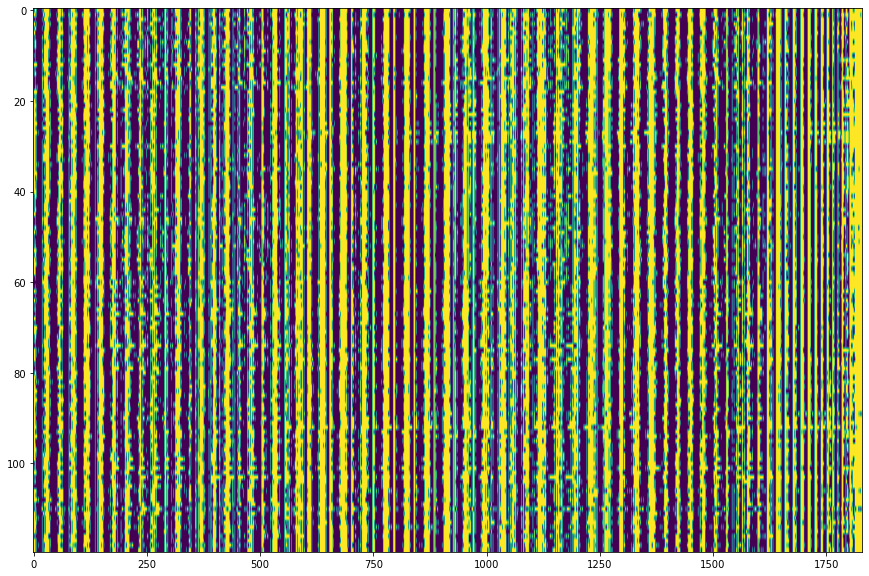

In [8]:
(X1,Y1)=makeTrain(6,20,500,'alpha','correlation',5)
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=10)

